In [1]:
import file_path as fp
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import math
import collections
import cv2
# import os
# from tensorflow.contrib.tensorboard.plugins import projector

In [2]:
input_data = pd.read_csv(fp.csv_folder+"mobile_data_info_train_competition.csv")

for col in input_data.columns.values:
    print(col, ": unique values =", len(input_data[col].unique()), ", non-empty rows =", len(input_data.dropna(subset=[col])))
    
# convert floating points class types to integer. Empty class type is filled with -1
input_data[input_data.columns.values[3:]] = input_data[input_data.columns.values[3:]].fillna(-1.0).astype(int)

itemid : unique values = 160330 , non-empty rows = 160330
title : unique values = 126719 , non-empty rows = 160330
image_path : unique values = 160330 , non-empty rows = 160330
Operating System : unique values = 8 , non-empty rows = 45278
Features : unique values = 8 , non-empty rows = 39345
Network Connections : unique values = 5 , non-empty rows = 23424
Memory RAM : unique values = 11 , non-empty rows = 57037
Brand : unique values = 56 , non-empty rows = 155038
Warranty Period : unique values = 15 , non-empty rows = 48073
Storage Capacity : unique values = 9 , non-empty rows = 63150
Color Family : unique values = 22 , non-empty rows = 84831
Phone Model : unique values = 620 , non-empty rows = 84509
Camera : unique values = 16 , non-empty rows = 24590
Phone Screen Size : unique values = 7 , non-empty rows = 32694


In [2]:
input_data = pd.read_pickle(fp.csv_folder+"mobile_preprocessed_with_resnet50_vector.pickle")

Looks like there are duplicated item titles

In [ ]:
# freq_dict = dict()
# for title in input_data.title.values:
#   if title in freq_dict:
#     freq_dict[title] += 1
#   else:
#     freq_dict[title] = 1
# for k, v in freq_dict.items():
#   if v > 1:
#     print(k)

In [10]:
def is_phone_number(string):
  if len(string) <= 3:
    return False
  digit_count = 0
  for char in string:
    if char.isdigit():
      digit_count += 1
      
  if digit_count > 3:
    return True
  
  return False

In [11]:
vocab_sentence = list()
sentence_id = 0

for line in input_data.title.values:
  tokens = line.split()
  for token in tokens:
    # remove telephone numbers
    if len(token) == 1 and not token.isdigit():
      continue
    if is_phone_number(token):
      continue
    if token == "whatsapp" or token == "wa":
      continue
      
    vocab_sentence.append((token, sentence_id))
  
  sentence_id += 1

vocabulary, sentence_id_map = list(zip(*vocab_sentence))
  
print('Data size', len(vocabulary))

Data size 1320090


In [12]:
import collections

vocabulary_size = 300

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
# del vocabulary  # Hint to reduce memory.
print('Most common words', count[1:6])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print("length of the dictionary: ", len(reverse_dictionary), "should be equal to", vocabulary_size)
print("least common words", count[-5:])

Most common words [('samsung', 33200), ('promo', 32830), ('garansi', 31128), ('iphone', 27436), ('1', 25020)]
Sample data [54, 4, 240, 246, 125, 0, 0, 13, 0, 133] ['apple', 'iphone', '4s', 'back', 'glass', 'UNK', 'UNK', 'original', 'UNK', 'putih']
length of the dictionary:  300 should be equal to 300
least common words [('international', 567), ('hybrid', 567), ('skin', 564), ('oneplus', 562), ('battery', 559)]


In [13]:
# calculate Term Frequency - Inverse Term Frequency for most common words
known_word_set = set([word for word, _ in count[1:]])

term_freq = dict()
inverse_term_freq = dict()
term_document_count = dict()

for itemid, title in input_data[["itemid", "title"]].values:
  tokens = title.split()
  unique_tokens = set()
  for token in tokens:
    if token not in known_word_set:
      continue
    if (itemid, token) in term_freq:
      term_freq[(itemid, token)] += 1
    else:
      term_freq[(itemid, token)] = 1
    unique_tokens.add(token)
    
  for token in unique_tokens:
    if token in term_document_count:
      term_document_count[token] += 1
    else:
      term_document_count[token] = 1  

n_documents = len(input_data)
for token, count in term_document_count.items():
  inverse_term_freq[token] = math.log(n_documents / count)

# no word is repeated in each title
for k, v in term_freq.items():
  if v > 1:
    print(k)

In [9]:
# data_index = 0
## original method for documentation purpose
# # Step 3: Function to generate a training batch for the skip-gram model.
# def generate_batch(batch_size, num_skips, skip_window):
#   global data_index
#   assert batch_size % num_skips == 0
#   assert num_skips <= 2 * skip_window
#   batch = np.ndarray(shape=(batch_size), dtype=np.int32)
#   labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
#   span = 2 * skip_window + 1  # [ skip_window target skip_window ]
#   buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
#   if data_index + span > len(data):
#       data_index = 0
#   buffer.extend(data[data_index:data_index + span])
#   data_index += span
#   for i in range(batch_size // num_skips):
#     context_words = [w for w in range(span) if w != skip_window]
#     words_to_use = random.sample(context_words, num_skips)
#     for j, context_word in enumerate(words_to_use):
#       batch[i * num_skips + j] = buffer[skip_window]
#       labels[i * num_skips + j, 0] = buffer[context_word]
#     if data_index == len(data):
#       buffer.extend(data[0:span])
#       data_index = span
#     else:
#       buffer.append(data[data_index])
#       data_index += 1
#   # Backtrack a little bit to avoid skipping words in the end of a batch
#   data_index = (data_index + len(data) - span) % len(data)
#   return batch, labels

# batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
# for i in range(8):
#   print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

4 iphone -> 55 apple
4 iphone -> 242 4s
242 4s -> 248 back
242 4s -> 4 iphone
248 back -> 242 4s
248 back -> 126 glass
126 glass -> 248 back
126 glass -> 0 UNK


In [14]:
data_index = 0
# new
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
      data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      if sentence_id_map[data_index-span+skip_window] == sentence_id_map[data_index-span+context_word]:
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[context_word]
      else:
        batch[i * num_skips + j] = 0
        labels[i * num_skips + j, 0] = 0
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=20, num_skips=2, skip_window=2)
print(input_data.title.head(2).values)
for i in range(20):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

['apple iphone 4s back glass spare part original replacement putih'
 'iphone 4s 64gb white']
240 4s -> 4 iphone
240 4s -> 54 apple
246 back -> 4 iphone
246 back -> 0 UNK
125 glass -> 246 back
125 glass -> 0 UNK
0 UNK -> 125 glass
0 UNK -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 13 original
13 original -> 0 UNK
13 original -> 0 UNK
0 UNK -> 133 putih
0 UNK -> 0 UNK
133 putih -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 0 UNK
0 UNK -> 0 UNK
240 4s -> 4 iphone


In [15]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 64  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))
    )
  with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(0.025).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
#   saver = tf.train.Saver()

In [26]:
# Step 5: Begin training.
data_index = 0

num_epochs = 10
num_steps = (len(data) * num_skips // batch_size + 1) * num_epochs
print("Steps to run:", num_steps)

with tf.Session(graph=graph) as session:
#   Open a writer to write summaries.
#   writer = tf.summary.FileWriter(fp.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
#     writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
#     if step == (num_steps - 1):
#       writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
#     if step % 10000 == 0:
#       sim = similarity.eval()
#       for i in range(valid_size):
#         valid_word = reverse_dictionary[valid_examples[i]]
#         top_k = 8  # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#         log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
#         print(log_str)
  
  sim = similarity.eval()
  for i in range(valid_size):
    valid_word = reverse_dictionary[valid_examples[i]]
    top_k = 8  # number of nearest neighbors
    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
    print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
#   with open(fp.log_dir + '/metadata.tsv', 'w') as f:
#     for i in range(vocabulary_size):
#       f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
#   saver.save(session, os.path.join(fp.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
#   config = projector.ProjectorConfig()
#   embedding_conf = config.embeddings.add()
#   embedding_conf.tensor_name = embeddings.name
#   embedding_conf.metadata_path = os.path.join(fp.log_dir, 'metadata.tsv')
#   projector.visualize_embeddings(writer, config)

# writer.close()

Steps to run: 206270
Initialized
Average loss at step  0 :  98.47953033447266
Average loss at step  2000 :  18.7902444858551
Average loss at step  4000 :  5.309098605513572
Average loss at step  6000 :  4.354899059176445
Average loss at step  8000 :  4.069713984131813
Average loss at step  10000 :  3.910880493044853
Average loss at step  12000 :  3.8258019343614578
Average loss at step  14000 :  3.7597778319120407
Average loss at step  16000 :  3.7165787223577498
Average loss at step  18000 :  3.6808412834405897
Average loss at step  20000 :  3.6534566336870196
Average loss at step  22000 :  3.6268440837860108
Average loss at step  24000 :  3.6143242989778517
Average loss at step  26000 :  3.593099790096283
Average loss at step  28000 :  3.592422089576721
Average loss at step  30000 :  3.5697011613845824
Average loss at step  32000 :  3.556378651857376
Average loss at step  34000 :  3.544054934024811
Average loss at step  36000 :  3.526822468161583
Average loss at step  38000 :  3.5239

In [17]:
# Step 6: Visualize the embeddings.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = min(500, vocabulary_size)
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
  return plt

[]

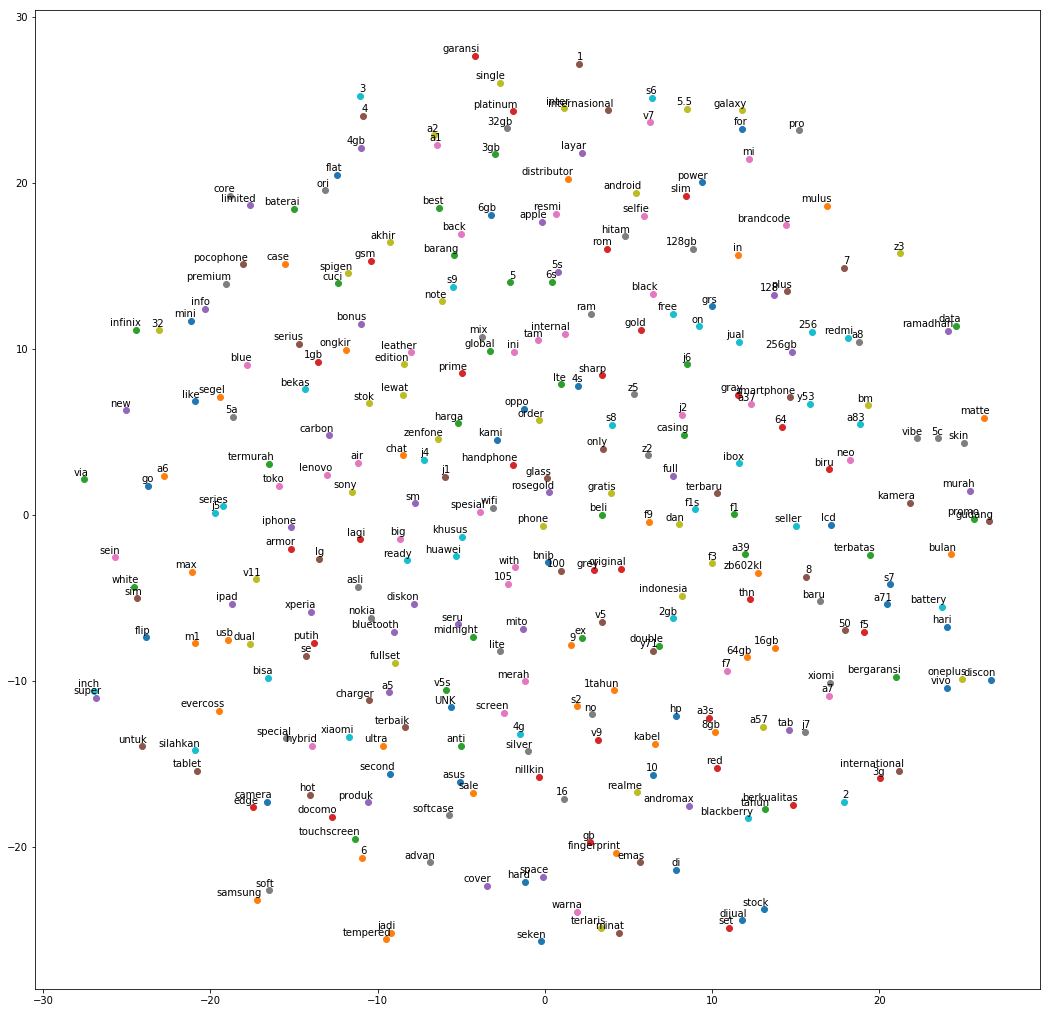

In [18]:
plot_with_labels(low_dim_embs, labels).plot()
# 2 skips, window size 1

[]

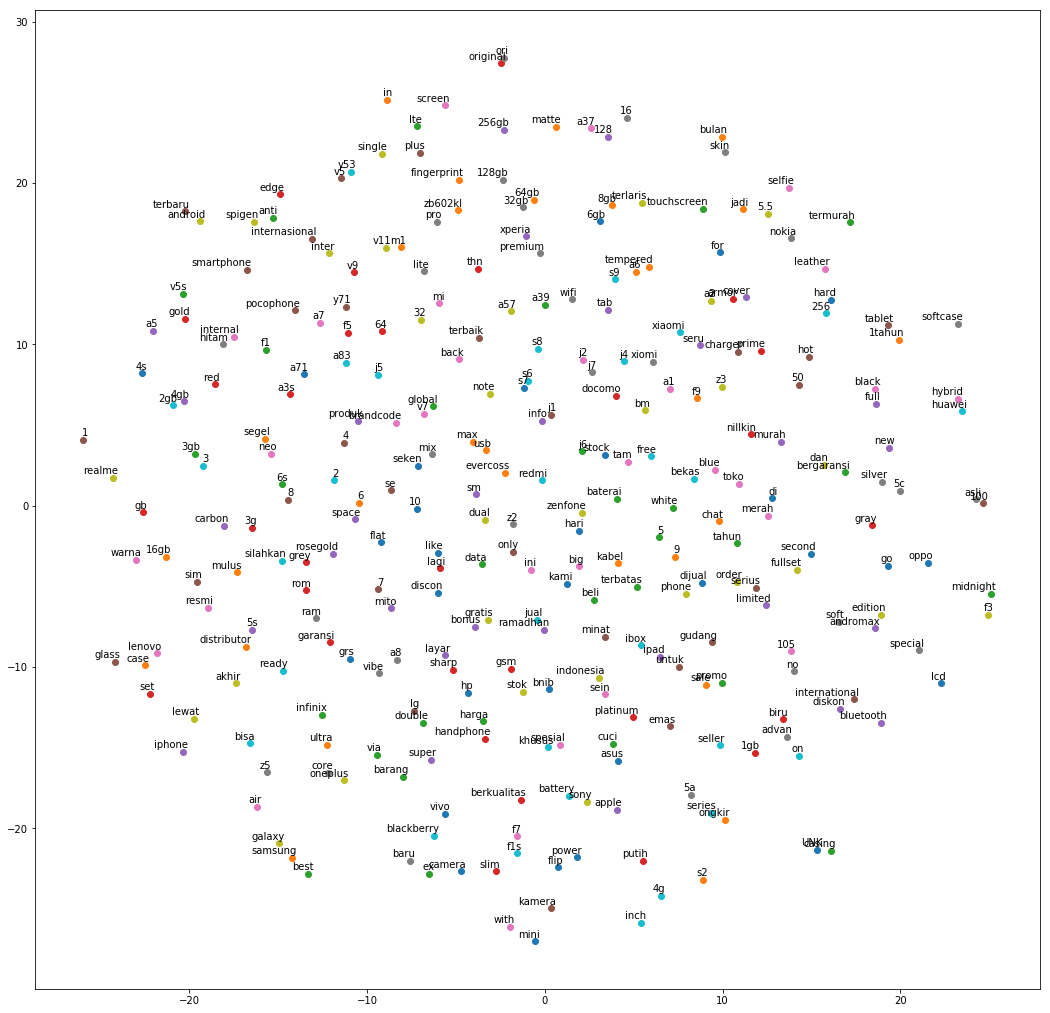

In [33]:
plot_with_labels(low_dim_embs, labels).plot()
# 2 skips, window size 1

Let's try to calculate the feature vector for each title using the the TF-IDF weighted word vector of known words

In [27]:
def get_avg_title_vector(itemid, title, use_tf_idf):
  tokens = title.split()
  total_score = 0.0
  total_vec = np.zeros(embedding_size)
  for token in tokens:
    if token not in known_word_set:
      continue
    word_vec = final_embeddings[dictionary[token]]
    if use_tf_idf:
      tf_idf_score = term_freq[(itemid, token)] * inverse_term_freq[token]
    else:
      tf_idf_score = 1.0
    total_score += tf_idf_score
    total_vec += word_vec * tf_idf_score
  
  if total_score == 0.0:
    return None
  return total_vec / total_score

input_data["title_vector"] = input_data.apply(lambda x: get_avg_title_vector(x.itemid, x.title, False), axis=1)

In [22]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(X, true_y):
  labels = input_data[y_col].unique()
  labels.sort()
  
  print(clf)
  print("Vector size", embedding_size, "; Vocab size", vocabulary_size,
        "; Num skips", num_skips, "; Skip window", skip_window)
  print(labels)
  print(confusion_matrix(true_y, clf.predict(X), labels=labels))

In [32]:
# Based on the competition submission result, we'll discard all empty tags

y_col = "Operating System"

from sklearn.model_selection import train_test_split
train, test = train_test_split(input_data[input_data[y_col] != -1].dropna(subset=["title_vector"]), test_size=0.2, random_state=12345)

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(np.stack(train.title_vector.values), train[y_col])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
from sklearn.metrics import confusion_matrix

labels = mobile_data[y_col].unique()
labels.sort()

print(labels)
print(confusion_matrix(test[y_col].values, clf.predict(np.stack(test.title_vector.values)),
                 labels=labels))

[-1  0  1  2  3  4  5  6]
[[21764     7    74    10    22     0     2   997]
 [   22    10     0     0     0     0     0     0]
 [  977     0   136     0     1     0     1    13]
 [   49     0     0     3     0     0     0     1]
 [  226     0     0     1    44     0     0    17]
 [    0     0     0     0     0     0     0     0]
 [    8     0     0     0     0     0     2     0]
 [ 5484     0     2     0     2     0     0  1968]]


use TF-IDF score to normalize impact of common words still appears to have better performance

In [121]:
from sklearn.metrics import confusion_matrix

labels = mobile_data[y_col].unique()
labels.sort()

print(labels)
print(confusion_matrix(test[y_col].values, clf.predict(np.stack(test.title_vector.values)),
                 labels=labels))

[-1  0  1  2  3  4  5  6]
[[21740     1    61     4    18     0     0  1025]
 [   24     8     0     0     0     0     0     0]
 [  967     0   151     0     0     0     0    10]
 [   49     0     0     4     0     0     0     2]
 [  240     0     0     0    57     0     0    15]
 [    1     0     0     0     0     0     0     0]
 [    4     0     0     0     0     0     0     0]
 [ 5379     0     7     1     4     0     0  2071]]


In [17]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# with tf-idf score

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[ 6295    12  2173    49    72     1     9 14104]
 [   11    14     0     0     0     0     0    10]
 [  190     0   662     0     0     0     0   251]
 [   23     2     0    21     0     0     0    14]
 [   24     1     2     1    64     0     0   224]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     5]
 [  337     1    54     1    12     0     0  7203]]


In [25]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# disabled tf-idf score

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[ 5948    12  2502    49    61     1     9 14133]
 [   12    13     0     0     0     0     0    10]
 [  163     0   748     0     0     0     0   192]
 [   23     2     0    21     0     0     0    14]
 [   24     1     1     2    57     0     0   231]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     5]
 [  313     1    64     1    12     0     0  7217]]


In [23]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# disabled tf-idf score and removed all -1 tages

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[   0    0    0    0    0    0    0    0]
 [   0   16    0    4    1    0    0   14]
 [   0    0  705    0    0    0    0  417]
 [   0    2    0   22    2    0    0   26]
 [   0    0    1    5   76    0    0  215]
 [   0    0    0    0    0    0    0    1]
 [   0    0    0    0    0    0    1    3]
 [   0    0   54   10   12    0    1 7381]]


In [25]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# disabled tf-idf score and removed all -1 tages

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 64 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[   0    0    0    0    0    0    0    0]
 [   0   16    0    4    1    0    0   14]
 [   0    0  773    0    0    0    0  349]
 [   0    2    0   23    2    0    0   25]
 [   0    0    1    5   77    0    0  214]
 [   0    0    0    0    0    0    0    1]
 [   0    0    0    0    0    0    1    3]
 [   0    0   61   11   12    0    1 7373]]


In [24]:
temp = test[["title", "Operating System"]]
temp["predicted_os"] = clf.predict(np.stack(test.title_vector.values))
temp[(temp["Operating System"] == 1) & (temp["predicted_os"] == 6)]

C:\Users\chenz\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,Operating System,predicted_os
107327,blackberry aurora,1,6
1355,oppo f5 black,1,6
144062,best seller conveter apple iphone 7 8 jack aud...,1,6
158613,rsim 11 solusi iphone ios 10 original murah,1,6
81490,new active iphone 5s 32 gb gold ready stock be...,1,6
143353,promo akhir bulan xiaomi note 4 gold fullset,1,6
111618,apple ipad pro gold tablet 128 gb,1,6
36001,ipad pro 2017 10.5 inch 256gb grey wifi cellular,1,6
128099,promo thr beli 2 gratis 1 iphone 6 gold 32gb g...,1,6
74648,promo cuci gudang info pemesanan via wa 62 831...,1,6


In [25]:
temp[temp["Operating System"]==3]

,title,Operating System,predicted_os
58159,best seller asus rog gl503ge i7 8750h 8gb 1tb ...,3,6
68663,lenovo thinkpad x240,3,6
158442,best seller seagate backup plus ultra slim har...,3,6
14970,chuwi vi8 plus dual os windows 10+android 5.1 ...,3,6
67413,4 lenovo ideapad b41 amd 4gb 500gb windows 10 ...,3,6
108358,term bosq hp 14 bw096tu amd a4 9120 ram 4gb hd...,3,6
131669,laptop toshiba dynabook ax55 tx65 warna putih,3,6
73631,pemesanan bulan puasa promo terbatas chat di w...,3,6
96543,beli 2 dapat 3 microsoft surface pro 5 7300u 4...,3,6
105686,1 langka lenovo tablet pc convertible touchscr...,3,6


In [18]:
clf.feature_importances_

array([0.02680677, 0.03015921, 0.03269704, 0.03979252, 0.02432418,
       0.02811599, 0.02514731, 0.02622634, 0.02675659, 0.02994319,
       0.02833968, 0.02629829, 0.02771391, 0.04967194, 0.02627824,
       0.04263372, 0.03602246, 0.03048933, 0.02823685, 0.02525861,
       0.02882704, 0.03355459, 0.0551984 , 0.02712904, 0.02597874,
       0.02508587, 0.02808761, 0.02572205, 0.02529292, 0.04525914,
       0.0415397 , 0.02741273])

Get feature vectors of images from pre-trained models. I've selected ResNet 50 and 152 for use here. Run 1 of the 2 following paragraphs

In [3]:
# ResNet 50. In this case I kept the global average that reduces output from 7x7x2048 to 2048
# NOTE: this uses Tensorflow's Keras-compatible API

resnet_features = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling="avg")
# 25 seconds to tag 1000 images on GTX 1050 Ti

In [4]:
# ResNet 152
# NOTE: this requires actual Keras pacakage
# download pretrained weights from https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6

from keras.models import Model
import pretrained_resnet

model = pretrained_resnet.resnet152_model(fp.image_base_folder+"resnet152_weights_tf.h5")
resnet_features = Model(inputs=model.input, outputs=model.layers[-2].output)
# 2 minutes to tag 1000 images on GTX 1050 Ti

In [5]:
def get_resnet_features(image_path):
  try:
    im = cv2.resize(cv2.imread(fp.image_base_folder+image_path), (224, 224)).astype(np.float32)
    # standardization: remove mean of ISLVRC2012 dataset
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    # Insert a new dimension for the batch_size
    im = np.expand_dims(im, axis=0)
    return resnet_features.predict(im)[0]
  except:
    return None

input_data["image_vector"] = input_data.apply(lambda x: get_resnet_features(x.image_path), axis=1)
# input_data.head(1000).apply(lambda x: get_resnet_features(x.image_path), axis=1)

In [28]:
input_data.to_pickle(fp.csv_folder+"mobile_preprocessed_with_resnet50_vector_and_word2vec.pickle")

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64, random_state=12345)

reduced_image_vector = pca.fit_transform(np.stack(input_data.image_vector.values))

input_data["image_vector_64"] = np.vsplit(reduced_image_vector, indices_or_sections=reduced_image_vector.shape[0])

let's combine both features

In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
clf.fit(np.concatenate(
  (np.stack(train.title_vector.values), np.stack(train.image_vector_64.values).reshape(-1, 64))
  , axis=1), train[y_col])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [75]:
print_confusion_matrix(
  np.concatenate(
  (np.stack(test.title_vector.values), np.stack(test.image_vector_64.values).reshape(-1, 64))
  , axis=1)
  , test[y_col].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 2
[-1  0  1  2  3  4  5  6]
[[ 4912     7  2391    25    15     0     0 15365]
 [   13     9     0     1     0     0     0    12]
 [  152     0   721     0     0     0     0   230]
 [   18     1     0    17     0     0     0    24]
 [   19     0     1     1    38     0     0   257]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     5]
 [  192     0    52     0     3     0     0  7361]]


In [34]:
print_confusion_matrix(
  np.concatenate(
  (np.stack(test.title_vector.values), np.stack(test.image_vector_64.values).reshape(-1, 64))
  , axis=1)
  , test[y_col].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 64 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[   0    0    0    0    0    0    0    0]
 [   0   14    0    4    1    0    0   16]
 [   0    0  757    0    0    0    0  365]
 [   0    1    0   21    0    0    0   30]
 [   0    0    1    1   85    0    0  210]
 [   0    0    0    0    0    0    0    1]
 [   0    0    0    0    0    0    1    3]
 [   0    1   45    2    4    0    0 7406]]


In [37]:
temp = test[["title", "Operating System"]]
temp["predicted_os"] = clf.predict(np.concatenate(
  (np.stack(test.title_vector.values), np.stack(test.image_vector_64.values).reshape(-1, 64))
  , axis=1))

C:\Users\chenz\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [56]:
temp[(temp["Operating System"] == 1) & (temp["predicted_os"] == 6)]

,title,Operating System,predicted_os
107327,blackberry aurora,1,6
133898,spesial promo rhamadan beli 2 bonus 1 apple ip...,1,6
1355,oppo f5 black,1,6
144062,best seller conveter apple iphone 7 8 jack aud...,1,6
158613,rsim 11 solusi iphone ios 10 original murah,1,6
81490,new active iphone 5s 32 gb gold ready stock be...,1,6
143353,promo akhir bulan xiaomi note 4 gold fullset,1,6
111618,apple ipad pro gold tablet 128 gb,1,6
36001,ipad pro 2017 10.5 inch 256gb grey wifi cellular,1,6
128099,promo thr beli 2 gratis 1 iphone 6 gold 32gb g...,1,6


In [55]:
dictionary["gb"]

33

In [43]:
def map_at_k(guesses, correct, k):
  for i in range(k):
    if guesses[i] == correct:
      return 1 / (i + 1)
  return 0.0

def probability_to_guesses(probs, k):
  np.argsort(probs)[-k:]